## Directional Coupler

In [ ]:
import numpy as np
print(np.__version__)
import gplugins.modes as gm
import meep as mp

1.26.4
2026-02-01 15:51:22.732 | INFO     | gplugins.gmeep:<module>:39 - Meep '1.30.0' installed at ['/home/hamish/miniconda3/envs/photonics/lib/python3.11/site-packages/meep']


Refractive index of even mode: 1.7813608443743267
Refractive index of odd mode: 1.773718114681965


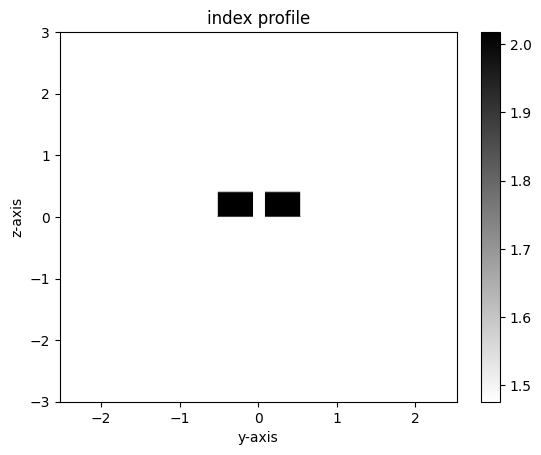

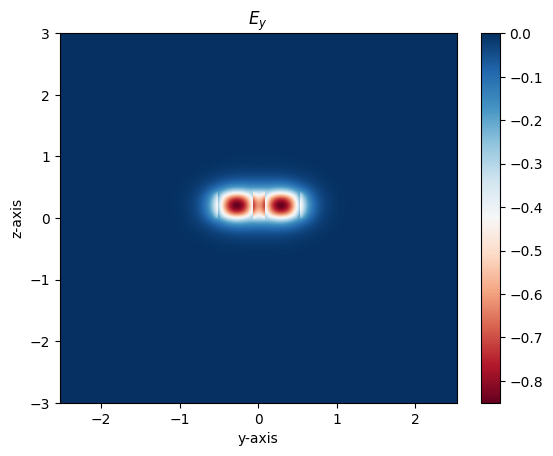

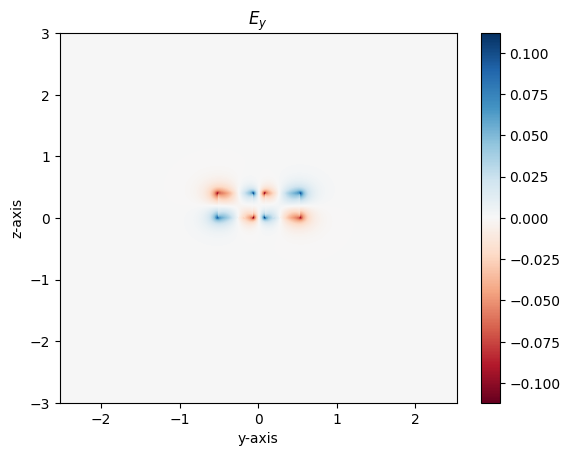

In [ ]:
w = 0.45  # core width in microns
t = 0.40  # core thickness in microns
res = 80  # resolution in pixels/um
wl = 0.810  # wavelength in microns

modes = gm.find_modes_coupler(
    core_widths=(w, w),
    gaps=(0.15,), # CHANGE GAP VALUE
    wavelength=wl,
    core_material=2.0176,  # SiN ANT
    clad_material=1.4759,  #SiO2 ANT
    core_thickness=t,
    resolution=res,
    sz=6,
    nmodes=2,
)


Refractive index of even mode: 1.7813608443743267
Refractive index of odd mode: 1.773718114681965


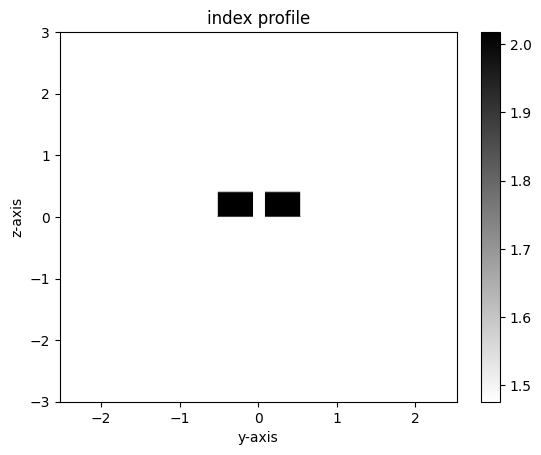

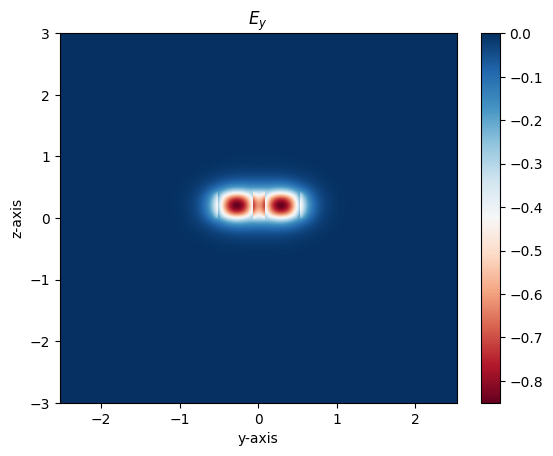

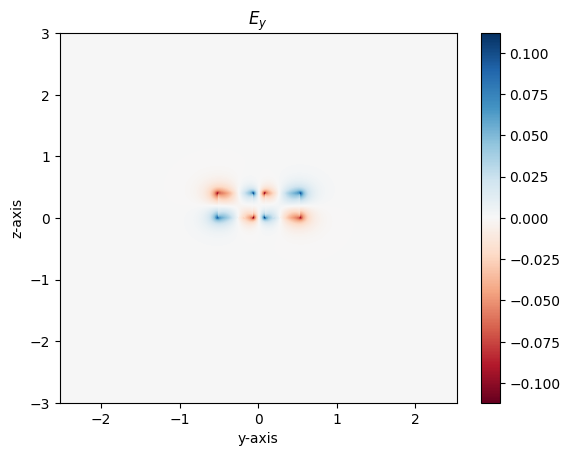

In [4]:

m1 = modes[1] # even mode
m2 = modes[2] # odd mode

# Look to see how big of a difference there is between the two refractive indices
print("Refractive index of even mode:", m1.neff)
print("Refractive index of odd mode:", m2.neff)

# Plot the dielectric, shows index of refraction values in sidebar
m1.plot_eps()

# Plot the Electric field intensity of the modes
m1.plot_ey()
m2.plot_ey()

In [ ]:
gm.find_coupling_vs_gap(gap1=0.15,
                        gap2=0.25,
                        steps=3,
                        nmodes=1,
                        wavelength=0.895,
                        parity=mp.EVEN_Y,
                        core_widths=(0.45, 0.45),
                        core_material=2.0176,
                        clad_material=1.4759,
                        core_thickness=0.40,
                        resolution=80,
                        sz=6,)

  0%|          | 0/14 [00:00<?, ?it/s]

,gap,ne,no,lc,dn
0,0.12,1.594712,1.569341,30.546496,0.025371
1,0.13,1.592006,1.568003,32.287003,0.024003
2,0.14,1.589616,1.566834,34.018470,0.022782
3,0.15,1.587358,1.565648,35.698021,0.021710
4,0.16,1.585147,1.564493,37.523683,0.020654
5,0.17,1.583115,1.563379,39.269856,0.019735
6,0.18,1.581309,1.562355,40.889678,0.018953
7,0.19,1.579347,1.561287,42.912384,0.018060
8,0.20,1.577673,1.560312,44.641000,0.017361
9,0.21,1.576021,1.559360,46.514835,0.016661


L_Barr = 35.698021
C_Cross = 17.8490105
C_5050 = 8.92450525


<Axes: xlabel='X', ylabel='Y'>

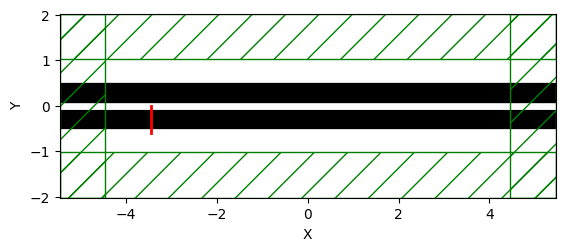

In [19]:
# Define materials
SiN = mp.Medium(index=2.0176)
SiO2 = mp.Medium(index=1.476)

# Define wavelength in um
wvl = 0.895

# # Define cell and geometric parameters
resolution = 40
wg_width = 0.45
dpml = 1
pad = 0.5

## CHANGE GAP DISTANCE ##
gap = 0.15
## CHANGE WAVEGUIDE LENGTH ##
Lx = 35.698021 / 1  # For Bar
print(f"L_Barr = {Lx}")
Lx = 35.698021 / 2  # For Cross
print(f"C_Cross = {Lx}")
Lx = 35.698021 / 4  # For 50/50
print(f"C_5050 = {Lx}")

Sx = dpml + Lx + dpml
Sy = dpml + pad + wg_width + gap + wg_width + pad + dpml
wg_center_y = gap/2 + wg_width/2

# Add PML (perfectly matched layers)
pml = [mp.PML(dpml)]

# Create 2 infinitely long parallel waveguides
geometry = [mp.Block(size=mp.Vector3(Sx,Sy, 0), center=mp.Vector3(), material=SiO2),
            mp.Block(size=mp.Vector3(Sx,wg_width, 0), center=mp.Vector3(0, wg_center_y, 0), material=SiN),
            mp.Block(size=mp.Vector3(Sx,wg_width, 0), center=mp.Vector3(0, -wg_center_y, 0), material=SiN),
            ]

# Put a pulse Eigenmode source at beginning of one waveguide
fcen = 1 / wvl
width = 0.1
fwidth = width * fcen
src=mp.GaussianSource(frequency=fcen, fwidth=fwidth)
source = [mp.EigenModeSource(src=src, eig_band=1,
        eig_kpoint = (1,0,0),
        size=mp.Vector3(0,gap+wg_width),
        center=mp.Vector3(-Sx/2+dpml+1, -wg_center_y))
        ]

# Simulation object
sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy),
    boundary_layers=pml,
    geometry=geometry,
    sources=source,
    default_material=SiO2,
    resolution=resolution,
)

# Show simulation set-up
sim.plot2D()

In [20]:
from PIL import Image
import glob
import os

sim.reset_meep()
# Capture electric field intensity over time and output into a gif
sim.run(mp.at_beginning(mp.output_epsilon),
        mp.to_appended("ez", mp.at_every(2, mp.output_efield_z)),
        until=200)

# Generate pngs from the simulation output
# This line assumes that colormaps are working, 
# you are in the same directory as the output files, 
# and that h5py is installed
# If you have a problem with h5utils, see note below
os.system("h5topng -t 0:99 -R -Zc RdBu -A eps-000000.00.h5 -a gray ez.h5")

# Create a gif from the pngs
frames = []
imgs = glob.glob("ez.t*")
imgs.sort()
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

# Save into a GIF file that loops forever
frames[0].save('ez.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               loop=0)

# Clean up workspace by deleting all generated images
for i in imgs: 
    os.remove(i)
for f in glob.glob("*.h5"):
    os.remove(f)

FloatProgress(value=0.0, description='0% done ', max=200.0)